In [17]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cmcrameri import cm
import numpy as np

In [18]:
## Import full enrichment results
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\workflow\pathway_enrichment\\"
kegg_permod = pd.read_csv(data_dir+"permod_KEGG.csv")
go_permod = pd.read_csv(data_dir+"permod_GO.csv")

for df in [kegg_permod, go_permod]:
    df.drop(columns=["Unnamed: 0", "module"], inplace=True)
    df.rename(columns={"Term": "pathway",
                       "Adjusted P-value":"q-value",
                       "Fold_Enrichment":"fold_enrichment"},
    inplace=True)

In [19]:
## Import filtered lists (filtered by SR)
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\data\filtered_lists\\"
kegg_top = pd.read_csv(data_dir+"permod_kegg_top.txt", sep="\t", header=None) # NP removed redundant pathways "Longevity regulating pathway - multiple species", "Apoptosis - multiple species"
kegg_ec =  pd.read_csv(data_dir+"permod_kegg_ec.txt", sep="\t", header=None)

go_top = pd.read_csv(data_dir+"permod_go_top.txt", sep="\t", header=None)
go_ec =  pd.read_csv(data_dir+"permod_go_ec.txt", sep="\t", header=None)

In [20]:
class Enrichment:
    def __init__(self, db, all_df, top_df, ec_df):
        self.database = db
        self.enrichment_df = all_df
        self.top_pathways = list(set(top_df[0]))
        self.endo_pathways = list(set(ec_df[0]))

In [21]:
GO_permod = Enrichment("GO BP", go_permod, go_top, go_ec)
KEGG_permod = Enrichment("KEGG", kegg_permod, kegg_top, kegg_ec)

In [22]:
def get_ec_df(full_df, ec_pthwys):
    filtered_df = full_df[full_df["pathway"].isin(ec_pthwys)]
    return filtered_df

In [23]:
def remove_duplicates_by_cohort(filtered_df):
    # Drop duplicates per cohort after sorting by fold_enrichment
    symp_df = filtered_df[filtered_df["cohort"] == "symptomatic"].sort_values(by="fold_enrichment", ascending=False).drop_duplicates(subset="pathway")
    asymp_df = filtered_df[filtered_df["cohort"] == "asymptomatic"].sort_values(by="fold_enrichment", ascending=False).drop_duplicates(subset="pathway")

    filtered_df = pd.concat([symp_df, asymp_df])
    return filtered_df
    

In [24]:
def get_pivot_df(filtered_df):
    pivot_df = filtered_df.pivot_table(index='pathway', columns='cohort', values='fold_enrichment')
    # Ensure 'symptomatic' and 'asymptomatic' columns exist with default values set to 1.0 if they don't
    if 'symptomatic' not in pivot_df.columns:
        pivot_df['symptomatic'] = np.nan
    if 'asymptomatic' not in pivot_df.columns:
        pivot_df['asymptomatic'] = np.nan
    
    # Reorder columns to ensure 'symptomatic' and 'asymptomatic' are in the right place if needed
    pivot_df = pivot_df[['asymptomatic', 'symptomatic']]

    pivot_df.fillna(1.0, inplace=True)
    return pivot_df

In [25]:
def filter_pivot_by_variation(pivot_df, n=30):
    variation = pivot_df.std(axis=1)
    top_n_labels = variation.nlargest(n).index
    filtered_pivot = pivot_df.loc[top_n_labels]
    return filtered_pivot

In [26]:
for Enr in [GO_permod, KEGG_permod]:
    full_df = Enr.enrichment_df
    ec_pthwys = Enr.endo_pathways
    # Only include pathways specified by SR
    filtered_df = get_ec_df(full_df, ec_pthwys)
    Enr.filtered_df = remove_duplicates_by_cohort(filtered_df)
    pivot_df = get_pivot_df(Enr.filtered_df)
    Enr.pivot_df = filter_pivot_by_variation(pivot_df)

## GO

In [27]:
def format_go_bp_label(go_bp_label):
    new_label = go_bp_label.split("(GO:")[0].rstrip()
    return new_label

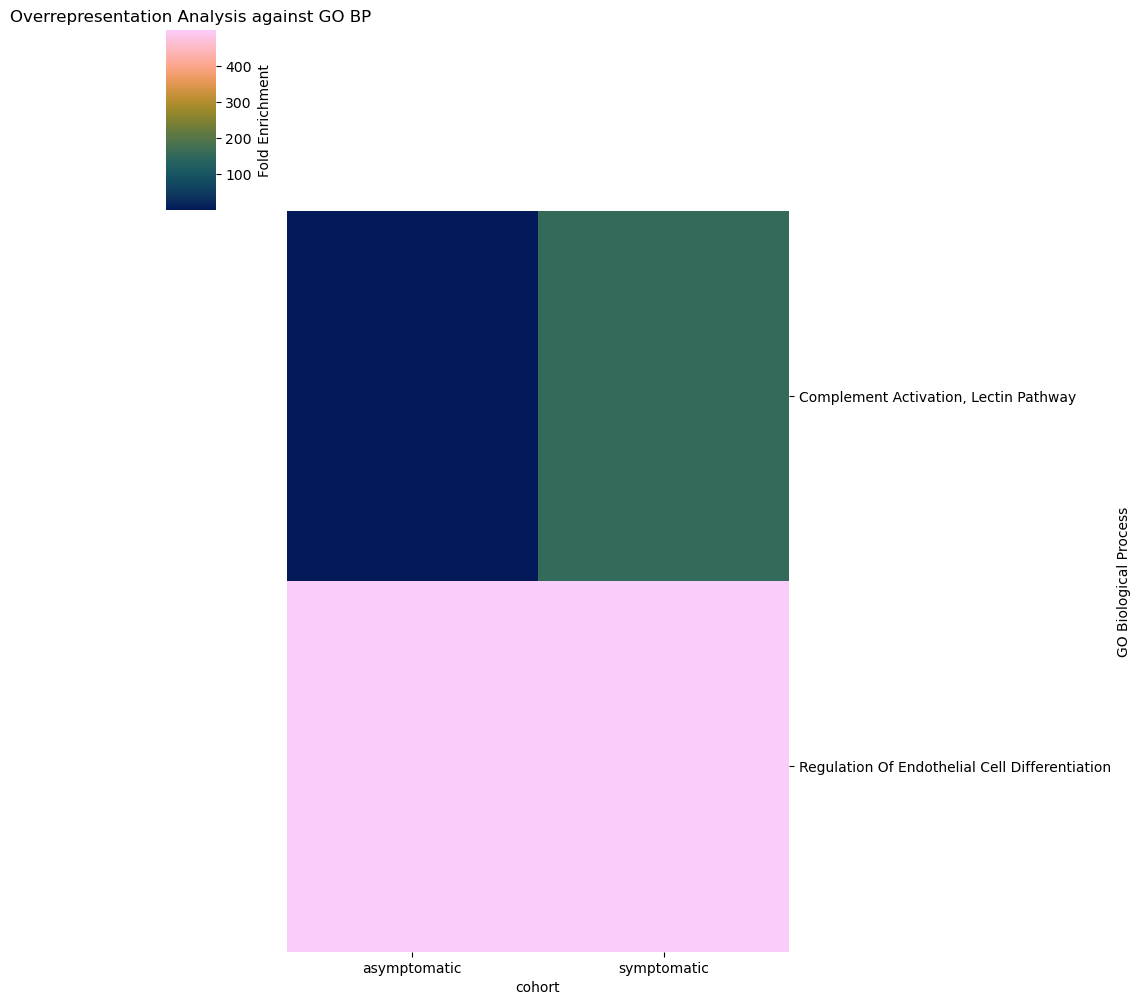

In [28]:
Enr = GO_permod
db = Enr.database
pivot_df = Enr.pivot_df.reset_index()
pivot_df["pathway"] = pivot_df["pathway"].apply(format_go_bp_label)
pivot_df.set_index("pathway", inplace=True)
pivot_df = pivot_df.rename_axis("GO Biological Process")

f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
plt.title(f'Overrepresentation Analysis against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"permod_go_heatmap_ec.pdf")
plt.show()

ANOVA test results: F-value = 0.06623918152704533, p-value = 0.8209529448486185
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2   meandiff p-adj   lower      upper   reject
-------------------------------------------------------------------
asymptomatic symptomatic  77.8162 0.821 -1223.0982 1378.7305  False
-------------------------------------------------------------------


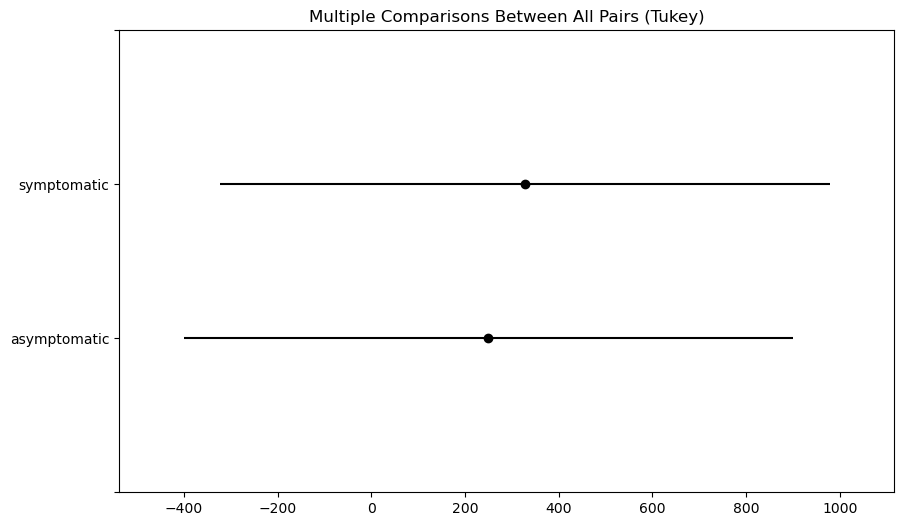

In [29]:
### Bar plots
# Perform ANOVA between cohorts for endo pathway overrep

from scipy import stats

fvalue, pvalue = stats.f_oneway(pivot_df['symptomatic'],
                                pivot_df['asymptomatic'])
print(f"ANOVA test results: F-value = {fvalue}, p-value = {pvalue}")

# Post-hoc Analysis (Tukey's HSD)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt



# Reshape the DataFrame for Tukey's HSD
melted_df = pivot_df.melt(var_name='cohort', value_name='value', ignore_index=False).reset_index()

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=melted_df['value'], groups=melted_df['cohort'], alpha=0.05)
tukey.plot_simultaneous()
print(tukey)


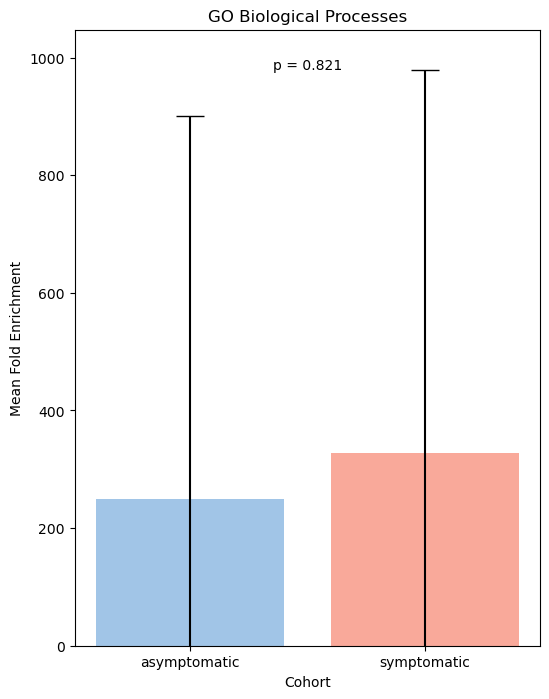

In [35]:
means = tukey._multicomp.groupstats.groupmean
error_bar_length = tukey.halfwidths[0]

# Lower ends of error bars
lowers = means - error_bar_length

# Upper ends of error bars
uppers = means + error_bar_length

# Define colors for each cohort
colors = {'asymptomatic': '#7AADDD', 'symptomatic': '#F78570'}

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(6,8))
cohorts = ['asymptomatic', 'symptomatic']
x_pos = range(len(cohorts))

# Create bars with error bars
bars = ax.bar(x_pos, means, yerr=error_bar_length, align='center', alpha=0.7, color=[colors[cohort] for cohort in cohorts], capsize=10)

# Adding labels
ax.set_xlabel('Cohort')
ax.set_ylabel('Mean Fold Enrichment')
ax.set_xticks(x_pos)
ax.set_xticklabels(cohorts)
ax.set_ylim(bottom=0)
ax.set_title('GO Biological Processes')

ax.text(0.5, 975, f'p = {pvalue:.3f}', ha='center', va='bottom')
# Show plot
plt.show()

fig.savefig(f"permod_go_tukey_ec.pdf")

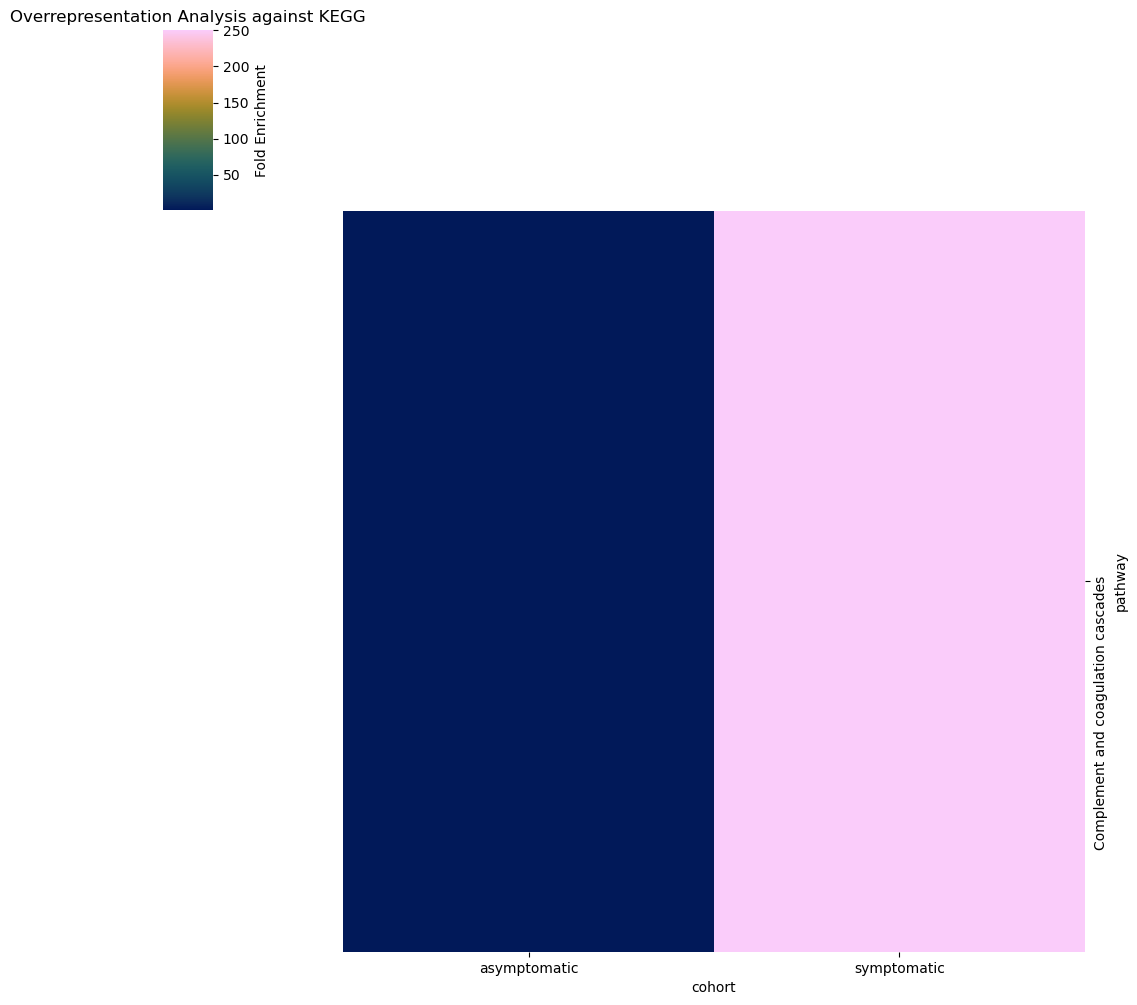

In [36]:
Enr = KEGG_permod
db = Enr.database
pivot_df = Enr.pivot_df

# Plot 30 pathways heatmap
f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
#f = sns.clustermap(pivot_df, cmap=cm.batlow, figsize=(12, 12), annot=False)

plt.title(f'Overrepresentation Analysis against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"permod_kegg_heatmap_ec.pdf")
plt.show()

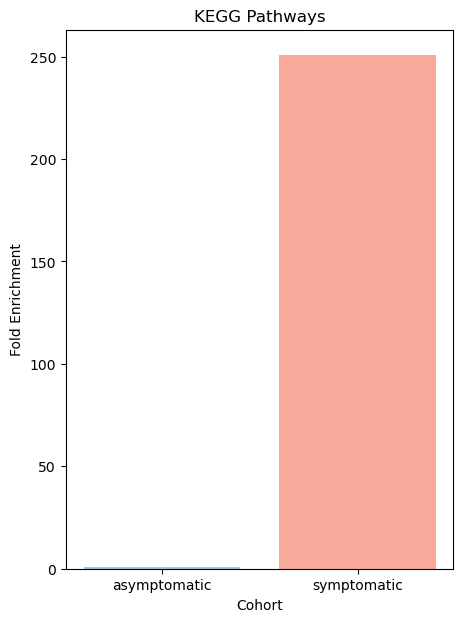

In [39]:
means = pivot_df.values[0]
# Plotting the bar graph
fig, ax = plt.subplots(figsize=(5,7))
cohorts = ['asymptomatic', 'symptomatic']
x_pos = range(len(cohorts))

# Define colors for each cohort
colors = {'asymptomatic': '#7AADDD', 'symptomatic': '#F78570'}
# Create bars with error bars
bars = ax.bar(x_pos, means, align='center', alpha=0.7, color=[colors[cohort] for cohort in cohorts], capsize=10)

# Adding labels
ax.set_xlabel('Cohort')
ax.set_ylabel('Fold Enrichment')
ax.set_xticks(x_pos)
ax.set_xticklabels(cohorts)
ax.set_ylim(bottom=0)
ax.set_title('KEGG Pathways')

#ax.text(0.5, 975, f'p = {pvalue:.3f}', ha='center', va='bottom')
# Show plot
plt.show()

fig.savefig(f"permod_kegg_tukey_ec.pdf")